# Overview
This notebook contains code for consuming model trained in notebook1.

# Assumption
This notebook assumes that we already have predefined parking locations marked w.r.t to each camera 

# Approach
### For prediction of parking locations on full parking test images from a given camera.
- Read test parking full image from filesystem
- Read coordinates of parking location from existing csv files containing predefined coordinates of parking locations
  with respect to each camera.
- Extract patches of parking locations using predefined coordinates.
- Predict whether each patch is busy/free and mark a rectangle of color red/green accordingly.
- Save predicted files to filesystem.

### For prediction of parking locations on video file for a given camera.
- Read video files containing generated from camera.
- Extract frames from it.
- Extract patches of parking location from each frame.
- Predict whether each patch is busy/free and mark a rectangle of color red/green accordingly.
- Write predicted frame to new video using opencv VideoWriter.
- Save predicted video to filesystem.

# Summary
- We have utilized trained model in previous notebook for generating inference on test images/test video.
- Model is able to predict busy/free parking locations in both images and video successfully.

### Import required packages

In [1]:
from os import listdir
from os.path import join, splitext, basename, dirname
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import cv2
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [2]:
from keras.models import model_from_json

Using TensorFlow backend.


### Read images specific to each camera

In [3]:
cam1_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera1/*.jpg"
cam2_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera2/*.jpg"
cam3_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera3/*.jpg"
cam4_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera4/*.jpg"
cam5_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera5/*.jpg"
cam6_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera6/*.jpg"
cam7_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera7/*.jpg"
cam8_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera8/*.jpg"
cam9_mask_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/*/*/camera9/*.jpg"

In [4]:
parking_locations_csv_base_path = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750"

In [5]:
parking_locations_csvs = [ join(parking_locations_csv_base_path, file) for file in listdir(parking_locations_csv_base_path) if ".csv" in file]

In [6]:
parking_locations_dict = {splitext(basename(csv_path))[0] : pd.read_csv(csv_path) for csv_path in parking_locations_csvs}

In [7]:
parking_locations_dict.keys()

dict_keys(['camera7', 'camera1', 'camera9', 'camera6', 'camera8', 'camera2', 'camera5', 'camera4', 'camera3'])

### camera 7 parking locations

In [8]:
print(parking_locations_dict['camera1'].head())

   SlotId     X     Y    W    H
0     603  1034  1640  240  240
1     604   718  1320  240  240
2     605   504  1126  200  200
3     606   306   944  180  180
4     607   169   811  150  150


In [9]:
NUM_THREADS = 12
BATCH_SIZE = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANNELS = 3

In [10]:
### we will extract images 

In [11]:
def get_imgs_for_camera(cam_mask_path):
    return [img for img in glob(cam_mask_path)]

In [12]:
cam1_imgs = get_imgs_for_camera(cam1_mask_path)
cam2_imgs = get_imgs_for_camera(cam2_mask_path)
cam3_imgs = get_imgs_for_camera(cam3_mask_path)
cam4_imgs = get_imgs_for_camera(cam4_mask_path)
cam5_imgs = get_imgs_for_camera(cam5_mask_path)
cam6_imgs = get_imgs_for_camera(cam6_mask_path)
cam7_imgs = get_imgs_for_camera(cam7_mask_path)
cam8_imgs = get_imgs_for_camera(cam8_mask_path)
cam9_imgs = get_imgs_for_camera(cam9_mask_path)

In [13]:
cam1_imgs[:5]

['/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_1640.jpg',
 '/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_1040.jpg',
 '/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_0910.jpg',
 '/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_0940.jpg',
 '/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_0810.jpg']

### Predict labels for parking locations in images and video files

In [14]:
def draw_rect_img_using_cv(img_fpath, annotated_fpath, rects, labels):
    '''
    draw rectangle over image
    '''
    source_img = cv2.imread(img_fpath)
    size = (2592, 1944)
    source_img = cv2.resize(source_img,size,interpolation = cv2.INTER_AREA)        
    for rect, label in zip(rects.values,labels):
        xmin, ymin, height, width = rect
        #print(xmin, ymin, height, width)        
        #draw.rectangle(((xmin, ymin), (xmin+width, ymin+height)), outline="#8B0000", width=5)
        color = None
        color = (0,0,255) if label == 1 else (0,255,0)            
        cv2.rectangle(source_img, (xmin,ymin), (xmin+width, ymin+height),color,5)
        #source_img[int(xmin+(width/2)): int(xmin+(width/2) + 10),int(ymin+(height/2)):int(ymin+(height/2) + 10)] = (255,255,255)
        #source_img[int(((2*xmin+width)/2)-5):int(((2*xmin+width)/2)+5),int(((2*ymin+height)/2)-5):int(((2*ymin+width)/2)+5)] = (255,255,255)
    cv2.imwrite(annotated_fpath, source_img)
    print("annotated: {0}".format(basename(img_fpath)))
    return source_img

In [15]:
# source_img_fpath = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/data/dataset1/CNR-EXT_FULL_IMAGE_1000x750/FULL_IMAGE_1000x750/OVERCAST/2015-11-29/camera1/2015-11-29_1640.jpg"
# #source_img_fpath = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/notebooks/source_img.jpg"
# annotated_fpath = "annotated.jpg"
# parking_locs_df = parking_locations_dict['camera1']
# parking_locs = parking_locs_df[['X','Y','W','H']]
# draw_rect_img_using_cv(source_img_fpath, annotated_fpath, parking_locs)

In [16]:
def read_parking_lot_image(img, camera_num):
    '''
    read an image from given img_fpath and reads into memory. Crops patches of parking location from each image 
    base on camera number, since we already know predefined parking locations with respect to each camera number.
    '''    
    if img is not None:
        size = (2592, 1944)
        parking_loc_patches=[]
        img = cv2.resize(img,size,interpolation = cv2.INTER_AREA)   
        #print('image is not none')
        camera_key= 'camera'+ str(camera_num)
        parking_locs_df = parking_locations_dict[camera_key]
        parking_locs = parking_locs_df[['X','Y','W','H']]
        parking_loc_patches= []
        for patch_index, parking_loc in enumerate(parking_locs.values):        
            X,Y,W,H = parking_loc
            # crop            
            img_patch = img[Y:Y+H,X:X+W,:]
            if img_patch is not None:
                #cv2.imwrite("parking_arr_{}.jpg".format(patch_index), img_patch)                
                img_patch = cv2.resize(img_patch,(IMG_HEIGHT,IMG_WIDTH), interpolation = cv2.INTER_AREA)
                #cv2.imwrite("parking_arr_resized_{}.jpg".format(patch_index), img_patch)                
                #print(img_patch.shape)
                #reshape
                #img_patch = np.reshape(img_patch, (-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
                #cv2.imwrite("parking_arr_reshaped_{}.jpg".format(patch_index), img_patch)
                #normalize
                img_patch = img_patch/255.0
                parking_loc_patches.append(img_patch)
        #return parking_loc_patches                    
        return np.array(parking_loc_patches)
        #return np.concatenate(parking_loc_patches, axis=0)                        
    else:
        print("image is none")

In [3]:
def load_model():
    '''
    load pretrained keras model from filesystem
    '''
    json_file = open('../trained_models/cnn_model/model.json', 'r')
    loaded_model = model_from_json(json_file.read())
    loaded_model.load_weights("../trained_models/cnn_model/model.h5")
    return loaded_model

In [4]:
pretrained_model = load_model()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
from keras.utils import plot_model
plot_model(pretrained_model, to_file='model.png'

In [19]:
def predict_labels(img_arrays):
    '''
    generate predictions on img_arrays using pretrained model
    '''
    predictions = pretrained_model.predict_on_batch(img_arrays)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes

### predict labels on test full parking images

In [20]:
def predict_labels_on_test_dataset():
    '''
    reads test images for predefined camera, extracts parking patches for each parking image w.r.t to camera number and draws rectangles
    w.r.t to labels generated by pretrained model for each of parking patch.
    '''
    predicted_imgs = []
    for index, cam_img in enumerate(cam3_imgs[10:50]):
        img =cv2.imread(cam_img)       
        img_arrays = read_parking_lot_image(img,3)
        
        # predict labels for arrays
        labels = predict_labels(img_arrays)
        parking_locs_df = parking_locations_dict['camera3']
        parking_locs = parking_locs_df[['X','Y','W','H']]
        predicted_img = draw_rect_img_using_cv(cam_img, "cam3_img_predicted_{}.jpg".format(index), parking_locs, labels)
        predicted_imgs.append(predicted_img)
    return predicted_imgs
        #for patch_index, parking_loc in enumerate(parking_locs.values)        
        # save predicted image         

In [21]:
predicted_imgs = predict_labels_on_test_dataset()

annotated: 2015-11-29_1516.jpg
annotated: 2015-11-29_0716.jpg
annotated: 2015-11-29_1446.jpg
annotated: 2015-11-29_1346.jpg
annotated: 2015-11-29_1616.jpg
annotated: 2015-11-29_1316.jpg
annotated: 2015-11-29_1146.jpg
annotated: 2015-11-29_0746.jpg
annotated: 2015-11-29_1116.jpg
annotated: 2015-11-29_1646.jpg
annotated: 2015-12-03_1246.jpg
annotated: 2015-12-03_0846.jpg
annotated: 2015-12-03_1116.jpg
annotated: 2015-12-03_1016.jpg
annotated: 2015-12-03_0946.jpg
annotated: 2015-12-03_1616.jpg
annotated: 2015-12-03_1646.jpg
annotated: 2015-12-03_0746.jpg
annotated: 2015-12-03_0816.jpg
annotated: 2015-12-03_1416.jpg
annotated: 2015-12-03_1516.jpg
annotated: 2015-12-03_1216.jpg
annotated: 2015-12-03_1346.jpg
annotated: 2015-12-03_1146.jpg
annotated: 2015-12-03_1046.jpg
annotated: 2015-12-03_1446.jpg
annotated: 2015-12-03_1316.jpg
annotated: 2015-12-03_1546.jpg
annotated: 2015-12-03_0716.jpg
annotated: 2015-12-03_0916.jpg
annotated: 2015-11-16_1115.jpg
annotated: 2015-11-16_1415.jpg
annotate

In [22]:
# plt.figure(figsize=(10,6))
# plt.subplot(1,3,1)
# plt.imshow(predicted_imgs[0])

# plt.figure(figsize=(10,6))
# plt.subplot(1,3,2)
# plt.imshow(predicted_imgs[15])

# plt.figure(figsize=(10,6))
# plt.subplot(1,3,3)
# plt.imshow(predicted_imgs[30])

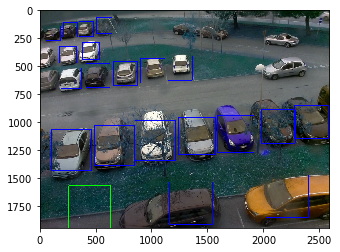

In [23]:
plt.imshow(predicted_imgs[15])

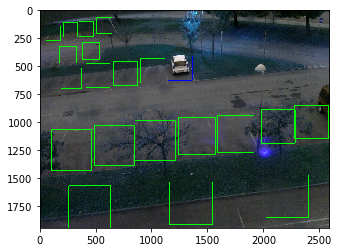

In [24]:
plt.imshow(predicted_imgs[1])

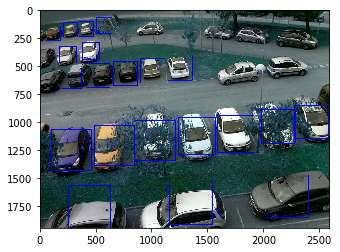

In [25]:
plt.imshow(predicted_imgs[30])

### Generate predictions on parking video files for a predefined camera

In [26]:
def predict_labels_on_video(video_fpath, camera_num):  
    '''
    reads video file from filesystem, extracts frames from it sequentially, generates predictions on it and saves predicted_frames into a separate video file.
    '''
    predicted_video_dir_path = dirname(video_fpath)
    predicted_file_without_extension = join(predicted_video_dir_path, "predicted_"+splitext(basename(video_fpath))[0])
    print(predicted_file_without_extension)
    
    VID_WIDTH = 2592
    VID_HEIGHT = 1944
    vidObj = cv2.VideoCapture(video_fpath)
    predictedVidObj = cv2.VideoWriter('{}.avi'.format(predicted_file_without_extension), cv2.VideoWriter_fourcc(*'DIVX'), 2, (VID_WIDTH, VID_HEIGHT))
    
    index = 0
    success =True
    while success:
        # read frame from source video
        success, image = vidObj.read()
        
        if image is not None:
            # read parking lot patches
            parking_patches = read_parking_lot_image(image, camera_num)

            # generate labels for parking patches using model
            predicted_labels = predict_labels(parking_patches)
#             predicted_labels = []
#             for parking_patch in parking_patches:
#                 if parking_patch is not None:
#                     predicted_labels.append(predict_labels(parking_patch))

            # get parking locations for given camera number
            parking_locs_df = parking_locations_dict['camera'+ str(camera_num)]
            parking_locs = parking_locs_df[['X','Y','W','H']]

            # resize image to fit to original scale
            size = (2592, 1944)
            image = cv2.resize(image,size,interpolation = cv2.INTER_AREA)        

            # iterate over each rectangle and color it according to predicted label
            for rect, label in zip(parking_locs.values[: len(predicted_labels)],predicted_labels):
                xmin, ymin, height, width = rect        
                color = None
                color = (0,0,255) if label == 1 else (0,255,0)            
                cv2.rectangle(image, (xmin,ymin), (xmin+width, ymin+height),color,5)  
            
            cv2.imwrite("predicted_{}.jpg".format(index), image)
            
            index +=1
            # write frame back to predicted video object
            predictedVidObj.write(image)
        
    # release handle of predicted video object
    predictedVidObj.release()
    print("created predicted video file successfully")

In [27]:
# video1_fpath= "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/videos/camera1.avi"
# predict_labels_on_video(video1_fpath, 1)
video_base_dir = "/home/anton/Workspace/Hackathons/jio_car_parking_challenge/videos"
for video_index, video_fpath in enumerate(listdir(video_base_dir)):
    camera_number = video_index+1
    camera_vid_file_name = "camera"+ str(camera_number)+ ".avi"
    predict_labels_on_video(join(video_base_dir, camera_vid_file_name), camera_number)    

/home/anton/Workspace/Hackathons/jio_car_parking_challenge/videos/predicted_camera1
created predicted video file successfully
/home/anton/Workspace/Hackathons/jio_car_parking_challenge/videos/predicted_camera2
created predicted video file successfully


In [28]:
#print(len(labels))

In [29]:
# #read_parking_lot_image("/home/anton/Workspace/Hackathons/jio_car_parking_challenge/notebooks/source_img.jpg",1)
# parking_arr= read_parking_lot_image(cam1_imgs[0],1)

In [30]:
# #parking_arr.shape
# print(len(parking_arr))

In [31]:
# for patch_index in range(len(parking_arr)):
#     cv2.imwrite('parking_arr_{}.jpg'.format(patch_index),parking_arr[patch_index])